In [1]:
print("good stuff")

good stuff


Markdown

In [1]:
#import some stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm
import glob
import time

In [2]:
convPath = 'nba-movement-data/data/converted'
#df = pd.read_csv('nba-movement-data\data\converted\0021500001_converted.csv')
oneGamedf = pd.read_csv(convPath + '/0021500001_converted.csv')
games = os.listdir(convPath)
#all_files = glob.glob(os.path.join(convPath, "*.csv"))
#df_from_each_file = (pd.read_csv(f) for f in all_files[0:3])
#concatenated_df   = pd.concat(df_from_each_file, ignore_index=True)

In [4]:
#one thing I could do with this is return one row per time with all the players on it
#just make it *player_id*speed/angle columns
import time
#speed and angle of player function
#returns new dataframe with speed and angle columns and only one row for each time
#input: df is a pandas dataframe
def getNewCols(df):
    import time
    start_time = time.time()
    concat_df = pd.DataFrame()
    df = df.copy()
    #df = df.loc[0:1000] #if we need to make it smaller for tests
    df2 = df.drop_duplicates(subset=['game_clock','player_id','quarter'])
    for player in df2['player_id'].unique():
        speeds = []
        angles = []
        player_df = df2.loc[df2['player_id'] == player].copy()
        
        #first 1 row just has the same speed as their next time
        """for index in range(1):
            temp1 = player_df.iloc[index + 1]
            temp2 = player_df.iloc[index]
            xspd = (temp1['x_loc'] - temp2['x_loc']) / (temp1['game_clock'] - temp2['game_clock'])
            yspd = (temp1['y_loc'] - temp2['y_loc']) / (temp1['game_clock'] - temp2['game_clock'])
            #xspd = (player_df.iloc[index + 1]['x_loc'] - player_df.iloc[index]['x_loc']) / (player_df.iloc[index + 1]['game_clock'] - df2.iloc[index]['game_clock'])
            spd = (xspd**2 + yspd**2)**0.5
            angles.append(math.atan2(yspd,xspd))
            speeds.append(spd)
        for index in range(1,len(player_df)):
            temp1 = player_df.iloc[index]
            temp2 = player_df.iloc[index - 1]
            xspd = (temp1['x_loc'] - temp2['x_loc']) / (temp1['game_clock'] - temp2['game_clock'])
            yspd = (temp1['y_loc'] - temp2['y_loc']) / (temp1['game_clock'] - temp2['game_clock'])
            spd = (xspd**2 + yspd**2)**0.5
            angles.append(math.atan2(yspd,xspd))
            speeds.append(spd)
            #index += 1
        
        
        #player_df = player_df[['player_id','game_clock']]
        player_df['speed'] = speeds
        player_df['angle'] = angles"""
        #this way is much faster
        player_df['testxSpeed'] = (player_df['x_loc'] - player_df['x_loc'].shift(1)) / (player_df['game_clock'] - player_df['game_clock'].shift(1))
        player_df['testySpeed'] = ((player_df['y_loc'] - player_df['y_loc'].shift(1)) / (player_df['game_clock'] - player_df['game_clock'].shift(1)))
        #newdf['testSpeed'] = (((newdf.x_loc - newdf.xloc.shift(1)) / (newdf.game_clock - newdf.game_clock.shift(1)))**2
        #                      ((newdf.y_loc - newdf.yloc.shift(1)) / (newdf.game_clock - newdf.game_clock.shift(1)))**2)**0.5
        player_df['speed'] = player_df.apply(lambda row: (row['testxSpeed']**2 + row['testySpeed']**2)**0.5,axis=1)
        player_df['angle'] = player_df.apply(lambda row: math.atan2(row['testySpeed'],row['testxSpeed']),axis=1)
        player_df = player_df.drop(columns = ['testxSpeed','testySpeed'])
        player_df.loc[player_df['speed'].isnull(),'speed'] = 0 #player_df.loc[1,'speed']
        player_df.loc[player_df['angle'].isnull(),'angle'] = 0 #player_df.loc[1,'angle']
        
        if player != -1:
            player_df.loc[player_df['speed'] > 372,['speed','angle']] = 0
            #player max speed isn't faster than Bolt
        else:
            player_df.loc[player_df['speed'] > 1000,['speed','angle']] = 0
            #very arbitrary max speed for ball chosen-around 75 mph I think
        concat_df = pd.concat([concat_df,player_df]) #use temp_df instead of player_df if using all duplicate times
        #print("--- %s seconds --- after another player" % (time.time() - start_time))
    
    print("--- %s seconds --- out of while loops" % (time.time() - start_time))
    #now we put all the same times values in one row
    concat_df = concat_df.sort_values(by=['game_clock'],ascending=False,kind='mergesort') #mergesort is only stable sort
    concat_df = concat_df.sort_values(by=['quarter'],ascending=True,kind='mergesort') 
    cols = ['game_clock','shot_clock','quarter','game_id','event_id','team_id1','player_id1','x_loc1','y_loc1','speed1','angle1',
           'radius1','team_id2','player_id2','x_loc2','y_loc2','speed2','angle2','radius2','team_id3','player_id3','x_loc3','y_loc3','speed3','angle3','radius3',
           'team_id4','player_id4','x_loc4','y_loc4','speed4','angle4','radius4','team_id5','player_id5','x_loc5','y_loc5','speed5','angle5','radius5',
           'team_id6','player_id6','x_loc6','y_loc6','speed6','angle6','radius6','team_id7','player_id7','x_loc7','y_loc7','speed7','angle7','radius7',
           'team_id8','player_id8','x_loc8','y_loc8','speed8','angle8','radius8','team_id9','player_id9','x_loc9','y_loc9','speed9','angle9','radius9',
           'team_id10','player_id10','x_loc10','y_loc10','speed10','angle10','radius10','team_id11','player_id11','x_loc11','y_loc11','speed11','angle11','radius11']
    final_df = pd.DataFrame(columns = cols)
    listoflists = []
    print("--- %s seconds --- at listoflists" % (time.time() - start_time))
    #badTimes = 0
    #could've used groupby, idiot
    for quarter in concat_df['quarter'].unique():
        quarter_df = concat_df.loc[concat_df['quarter'] == quarter]
        #startIndex = 0
        #endIndex = 25
        for quarterTime in quarter_df['game_clock'].unique():
            #quarter_dfTemp = quarter_df.iloc[startIndex:endIndex]
            #base_df = quarter_dfTemp.loc[quarter_dfTemp['game_clock'] == quarterTime]
            base_df = quarter_df.loc[quarter_df['game_clock'] == quarterTime] #use this if no start/end index
            tempList = base_df.iloc[0][['game_clock','shot_clock','quarter','game_id','event_id']].tolist()
            if len(base_df) == 11:
                for i in range(11):
                    tempPlayerList = base_df.iloc[i][['team_id','player_id','x_loc','y_loc','speed','angle','radius']].tolist()
                    tempList += tempPlayerList
                #startIndex += 11
                #endIndex += 11
                #base_df = base_df[['game_clock','team_id','player_id','x_loc','y_loc','speed','angle','radius']]
                #tempPlayerList = base_df.groupby(by=['game_clock'])[['team_id','player_id','x_loc','y_loc','speed','angle','radius']].apply(lambda x: pd.DataFrame(x.values)).unstack().iloc[0].tolist()
                #tempList += tempPlayerList
                listoflists.append(tempList)
            #else:
            #    startIndex += len(base_df)
            #    endIndex += len(base_df)
            #    badTimes += 1
        print("--- %s seconds --- after a quarter" % (time.time() - start_time))
    final_df = final_df.append(pd.DataFrame(listoflists,columns=cols))
    #print("badtime is ",badTimes)
    
    return final_df

In [5]:
start_time = time.time()
dfFinal = getNewCols(oneGamedf)
print("--- %s seconds --- in total" % (time.time() - start_time))

--- 62.684003829956055 seconds --- out of while loops
--- 63.19459652900696 seconds --- at listoflists
--- 334.05890011787415 seconds --- after a quarter
--- 600.356335401535 seconds --- after a quarter
--- 936.920343875885 seconds --- after a quarter
--- 1215.8650212287903 seconds --- after a quarter
--- 1217.7213110923767 seconds --- in total


pretty good!
--- 85.29071950912476 seconds --- out of while loops
--- 85.76682186126709 seconds --- at listoflists --after here bad
--- 394.451495885849 seconds --- after a quarter
--- 728.1594481468201 seconds --- after a quarter
--- 1048.0747113227844 seconds --- after a quarter
--- 1361.1476881504059 seconds --- after a quarter
--- 1363.4644923210144 seconds --- in total

for temp1 = player_df.iloc[index]
--- 442.771856546402 seconds --- out of while loops
--- 443.17809224128723 seconds --- at listoflists
--- 699.8945081233978 seconds --- after a quarter
--- 969.5106930732727 seconds --- after a quarter
--- 1236.9052748680115 seconds --- after a quarter
--- 1500.3029634952545 seconds --- after a quarter
bad time amount is  151
--- 1501.978367805481 seconds --- in total


In [6]:
#newmerged_df2.loc[0,'angle11'] = newmerged_df2.loc[1,'angle11']
pd.set_option('display.max_columns', None)

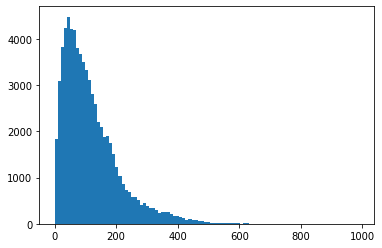

In [7]:
mySpeeds = dfFinal['speed1'].tolist()
plt.hist(mySpeeds,bins=100)
plt.show()

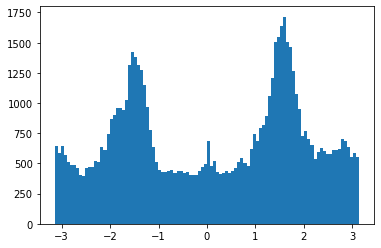

In [8]:
myAngles = dfFinal['angle2'].tolist()
plt.hist(myAngles,bins=100)
plt.show()

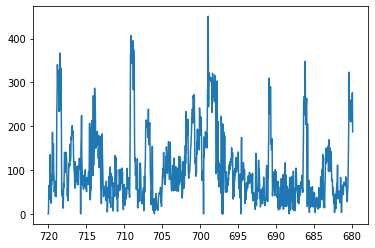

In [9]:
#speed of the ball as we go through a play - seems reasonable
ball = dfFinal[dfFinal['player_id1'] == -1]
ball = ball[0:1000]
plt.plot(ball['game_clock'],ball['speed1'])
plt.gca().invert_xaxis()
plt.show()

In [10]:
dfFinal.head()

,game_clock,shot_clock,quarter,game_id,event_id,team_id1,player_id1,x_loc1,y_loc1,speed1,angle1,radius1,team_id2,player_id2,x_loc2,y_loc2,speed2,angle2,radius2,team_id3,player_id3,x_loc3,y_loc3,speed3,angle3,radius3,team_id4,player_id4,x_loc4,y_loc4,speed4,angle4,radius4,team_id5,player_id5,x_loc5,y_loc5,speed5,angle5,radius5,team_id6,player_id6,x_loc6,y_loc6,speed6,angle6,radius6,team_id7,player_id7,x_loc7,y_loc7,speed7,angle7,radius7,team_id8,player_id8,x_loc8,y_loc8,speed8,angle8,radius8,team_id9,player_id9,x_loc9,y_loc9,speed9,angle9,radius9,team_id10,player_id10,x_loc10,y_loc10,speed10,angle10,radius10,team_id11,player_id11,x_loc11,y_loc11,speed11,angle11,radius11
0,720.00,24.00,1.0,21500001.0,1.0,-1.0,-1.0,11.4806,419.9969,0.000000,0.000000,6.76567,1.610613e+09,2594.0,94.2130,409.5423,0.000000,0.000000,0.0,1.610613e+09,200794.0,-20.4121,323.7984,0.000000,0.000000,0.0,1.610613e+09,201143.0,-5.2384,419.8086,0.000000,0.000000,0.0,1.610613e+09,201952.0,12.6600,235.1728,0.000000,0.000000,0.0,1.610613e+09,203145.0,-67.4141,358.4368,0.000000,0.000000,0.0,1.610613e+09,101141.0,5.1460,329.7306,0.000000,0.000000,0.0,1.610613e+09,202704.0,4.8774,156.0893,0.000000,0.000000,0.0,1.610613e+09,202694.0,102.6915,406.0077,0.000000,0.000000,0.0,1.610613e+09,203484.0,-104.4564,407.8648,0.000000,0.000000,0.0,1.610613e+09,203083.0,-6.3552,417.3551,0.000000,0.000000,0.0
1,719.98,23.90,1.0,21500001.0,1.0,-1.0,-1.0,26.8673,357.7526,0.000000,0.000000,6.47278,1.610613e+09,2594.0,91.9093,411.3531,146.509644,-0.666171,0.0,1.610613e+09,200794.0,40.3812,286.9045,0.000000,0.000000,0.0,1.610613e+09,201143.0,0.6175,415.2281,371.727538,2.477798,0.0,1.610613e+09,201952.0,10.0541,263.1622,0.000000,0.000000,0.0,1.610613e+09,203145.0,-68.5519,359.2765,70.705108,-0.635779,0.0,1.610613e+09,101141.0,24.0656,333.5297,0.000000,0.000000,0.0,1.610613e+09,202704.0,10.4006,167.1571,0.000000,0.000000,0.0,1.610613e+09,202694.0,112.4572,400.2316,0.000000,0.000000,0.0,1.610613e+09,203484.0,-105.0472,405.7281,110.843714,1.301035,0.0,1.610613e+09,203083.0,3.4147,414.6780,0.000000,0.000000,0.0
2,719.94,23.86,1.0,21500001.0,1.0,-1.0,-1.0,25.1361,357.9653,43.605438,-0.122250,6.09299,1.610613e+09,2594.0,91.7820,410.9989,9.409534,1.225771,0.0,1.610613e+09,200794.0,41.6891,285.6228,45.780436,2.366312,0.0,1.610613e+09,201143.0,-1.0921,414.1357,50.720249,0.568589,0.0,1.610613e+09,201952.0,9.8378,264.0084,21.835180,-1.320542,0.0,1.610613e+09,203145.0,-68.6526,358.9910,7.568468,1.231705,0.0,1.610613e+09,101141.0,25.6813,333.3388,40.673466,3.023985,0.0,1.610613e+09,202704.0,9.8595,167.8137,21.270766,-0.881536,0.0,1.610613e+09,202694.0,113.2958,401.2330,32.653981,-2.267946,0.0,1.610613e+09,203484.0,-105.0160,405.9587,5.817527,-1.705279,0.0,1.610613e+09,203083.0,4.0251,413.8486,25.745054,2.205247,0.0
3,719.90,23.82,1.0,21500001.0,1.0,-1.0,-1.0,25.0770,355.3443,65.541656,1.548252,6.16468,1.610613e+09,2594.0,91.5735,410.5242,12.961779,1.156939,0.0,1.610613e+09,200794.0,42.7647,284.3599,41.471615,2.276271,0.0,1.610613e+09,201143.0,-2.7554,413.4387,45.085862,0.396817,0.0,1.610613e+09,201952.0,9.7443,264.8625,21.480064,-1.461759,0.0,1.610613e+09,203145.0,-68.7235,358.6628,8.394271,1.358039,0.0,1.610613e+09,101141.0,26.7224,332.9735,27.583207,2.804135,0.0,1.610613e+09,202704.0,9.0623,168.4118,24.915500,-0.643662,0.0,1.610613e+09,202694.0,114.2276,402.3531,36.425225,-2.264682,0.0,1.610613e+09,203484.0,-104.6349,406.8624,24.519264,-1.969878,0.0,1.610613e+09,203083.0,4.8383,413.1746,26.405140,2.449521,0.0
4,719.86,23.78,1.0,21500001.0,1.0,-1.0,-1.0,24.0813,353.8495,44.901597,0.983180,6.11854,1.610613e+09,2594.0,91.3960,410.0425,12.834065,1.217748,0.0,1.610613e+09,200794.0,43.1455,283.3925,25.991241,1.945801,0.0,1.610613e+09,201143.0,-4.7322,411.6761,66.212239,0.728179,0.0,1.610613e+09,201952.0,9.7802,265.7354,21.840948,-1.611900,0.0,1.610613e+09,203145.0,-68.8247,358.2557,10.487250,1.327147,0.0,1.610613e+09,101141.0,27.9355,332.9618,30.328911,3.131948,0.0,1.610613e+09,202704.0,7.8756,168.9164,32

In [11]:
df = dfFinal.copy()

In [12]:
oneGamedf.dtypes

team_id             int64
player_id           int64
x_loc             float64
y_loc             float64
radius            float64
game_clock        float64
shot_clock        float64
quarter             int64
game_id             int64
event_id            int64
x_loc_original    float64
y_loc_original    float64
dtype: object

In [13]:
start_time = time.time()
df = df.astype({'team_id1':'int64','team_id2':'int64','team_id3':'int64','team_id4':'int64','team_id5':'int64',
                               'team_id6':'int64','team_id7':'int64','team_id8':'int64','team_id9':'int64','team_id10':'int64',
                               'team_id11':'int64','quarter':'int64','game_id':'int64','event_id':'int64','player_id1':'int64',
                               'player_id2':'int64','player_id3':'int64','player_id4':'int64','player_id5':'int64','player_id6':'int64',
                               'player_id7':'int64','player_id8':'int64','player_id9':'int64','player_id10':'int64','player_id11':'int64'})
print("time is ",(time.time() - start_time))

time is  0.10225057601928711


In [20]:
shotPath = 'nba-movement-data/data/shots'
shots = pd.read_csv(shotPath + '/shots_fixed.csv')
eventPath = 'nba-movement-data/data/events'
events = pd.read_csv(eventPath + '/0021500001.csv')

In [21]:
def getShotsReady(df):
    df = df.copy()
    df = df.sort_values(by=['SHOT_TIME'],ascending=False,kind='mergesort')
    df = df.sort_values(by=['GAME_ID','QUARTER'],ascending=True,kind='mergesort')
    df['madeShot'] = df.apply(lambda row: row['EVENT_TYPE'].find('Made') != -1,axis=1)
    df['possPoints'] = df.apply(lambda row: row['madeShot'] * float(row['SHOT_TYPE'][0:1]),axis=1)
    df['isShot'] = df.apply(lambda row: True,axis=1)
    return df

In [62]:
def getEventsReady(df):
    df = df.copy()
    df = df.astype({'HOMEDESCRIPTION':'str','VISITORDESCRIPTION':'str'})
    #can make these
    df['isTO'] = df.apply(lambda row: (row['HOMEDESCRIPTION'].find('Turnover') != -1) | (row['VISITORDESCRIPTION'].find('Turnover') != -1),axis=1)
    df['isFT'] = df.apply(lambda row: (row['HOMEDESCRIPTION'].find('Free Throw') != -1) | (row['VISITORDESCRIPTION'].find('Free Throw') != -1),axis=1)
    df['isReb'] = df.apply(lambda row: (row['HOMEDESCRIPTION'].find('REBOUND') != -1) | (row['VISITORDESCRIPTION'].find('REBOUND') != -1),axis=1)
    df['isFTMade'] = df.apply(lambda row: row['isFT'] & ((row['VISITORDESCRIPTION'].find('MISS') == -1) & (row['HOMEDESCRIPTION'].find('MISS') == -1)),axis=1)
    
    df['isFTMade'] = df.apply(lambda row: 0 if pd.isnull(row['isFTMade']) else row['isFTMade'] * 1,axis=1)
    df['isFT'] = df.apply(lambda row: 0 if pd.isnull(row['isFT']) else row['isFT'] * 1,axis=1)
    tempdf = df.loc[df['isFT'] == 1].copy()
    tempdf['isFTMade2'] = tempdf['isFTMade'].shift(-1,fill_value=0)
    tempdf['isFTMade3'] = tempdf['isFTMade'].shift(-2,fill_value=0)
    tempdf = tempdf[['EVENTNUM','isFTMade2','isFTMade3']]
    df = df.merge(tempdf,how='left',on='EVENTNUM')
    df['isFTMade2'] = df.apply(lambda row: 0 if pd.isnull(row['isFTMade2']) else row['isFTMade2'],axis=1)
    df['isFTMade3'] = df.apply(lambda row: 0 if pd.isnull(row['isFTMade3']) else row['isFTMade3'],axis=1)
    
    df['AmountFTs'] = np.zeros(len(df))
    def fixAmountFTs(row,description):
        index = row[description].find('Free Throw')
        if index != -1:
            if row[description].find('Technical') != -1:
                return 1
            elif row[description].find('Clear Path') != -1:
                return row[description][index+27:index+28]
            elif row[description].find('Flagrant') != -1:
                return row[description][index+25:index+26]
            else:
                return row[description][index+16:index+17] 
        else:
            return row['AmountFTs']
    df['AmountFTs'] = df.apply(lambda row: fixAmountFTs(row,'HOMEDESCRIPTION'),axis=1)
    df['AmountFTs'] = df.apply(lambda row: fixAmountFTs(row,'VISITORDESCRIPTION'),axis=1)
    df = df.astype({'AmountFTs':'int64'})
    def getFTsMade(row):
        made = row['isFTMade']
        index = 2
        while index <= row['AmountFTs']:
            col = 'isFTMade' + str(index)
            made += row[col]
            index += 1
        return made
    #note: FTs Made is only accurate for first free throw
    #      This is because we only use that one
    df['FTsMade'] = df.apply(lambda row: getFTsMade(row),axis=1)
    return df

In [23]:
shots = getShotsReady(shots)
events = getEventsReady(events)

In [24]:
def getFinalDF(events,shots,gameDF):
    gameDF = gameDF.copy()
    tempevents = events[['EVENTNUM','isTO','isFT','isReb','isFTMade','FTsMade','PLAYER1_ID','PLAYER1_NAME']].copy() #also possibly have game_id in future
    tempevents = tempevents.rename(columns={'PLAYER1_ID':'NonShotPlayerID','PLAYER1_NAME':'NonShotPlayerName'})
    gameDF = gameDF.merge(tempevents,how='left',left_on='event_id',right_on='EVENTNUM')
    tempshots = shots.loc[shots['GAME_ID'] == 21500001].copy() #this will need to be changed in future
    tempshots = tempshots[['GAME_EVENT_ID','PLAYER_ID','PLAYER_NAME','SHOT_TIME','possPoints','isShot']].copy() #also have GAME_ID in future
    tempshots = tempshots.rename(columns={'PLAYER_ID':'ShotPlayerID','PLAYER_NAME':'ShotPlayerName'})
    gameDF = gameDF.merge(tempshots,how='left',left_on='event_id',right_on='GAME_EVENT_ID')
    gameDF = gameDF.drop(columns=['EVENTNUM','GAME_EVENT_ID'])
    gameDF['isShot'] = gameDF.apply(lambda row: False if pd.isnull(row['possPoints']) else row['isShot'],axis=1)
    def getPosspoints(row):
        if pd.isnull(row['possPoints']):
            if row['isFT']:
                return row['FTsMade']
            else:
                return 0
        else:
            return row['possPoints']
        
    gameDF['possPoints'] = gameDF.apply(lambda row: getPosspoints(row),axis=1)
    return gameDF

In [25]:
#columns to add to main df
#poss.Points,poss.player,nextShotTime,nextShotShooter

In [26]:
newtest = getFinalDF(events,shots,dfFinal)

In [28]:
newtest.loc[newtest['event_id'] == 279].head()

,game_clock,shot_clock,quarter,game_id,event_id,team_id1,player_id1,x_loc1,y_loc1,speed1,angle1,radius1,team_id2,player_id2,x_loc2,y_loc2,speed2,angle2,radius2,team_id3,player_id3,x_loc3,y_loc3,speed3,angle3,radius3,team_id4,player_id4,x_loc4,y_loc4,speed4,angle4,radius4,team_id5,player_id5,x_loc5,y_loc5,speed5,angle5,radius5,team_id6,player_id6,x_loc6,y_loc6,speed6,angle6,radius6,team_id7,player_id7,x_loc7,y_loc7,speed7,angle7,radius7,team_id8,player_id8,x_loc8,y_loc8,speed8,angle8,radius8,team_id9,player_id9,x_loc9,y_loc9,speed9,angle9,radius9,team_id10,player_id10,x_loc10,y_loc10,speed10,angle10,radius10,team_id11,player_id11,x_loc11,y_loc11,speed11,angle11,radius11,isTO,isFT,isReb,isFTMade,FTsMade,NonShotPlayerID,NonShotPlayerName,ShotPlayerID,ShotPlayerName,SHOT_TIME,possPoints,isShot
41161,503.11,23.99,3.0,21500001.0,279.0,-1.0,-1.0,70.0557,61.2584,957.632957,-0.787493,4.43006,1.610613e+09,2594.0,-148.9173,325.3576,0.000000,0.000000,0.0,1.610613e+09,200794.0,-51.9791,234.0837,0.000000,0.000000,0.0,1.610613e+09,201143.0,5.6127,317.0722,0.000000,0.000000,0.0,1.610613e+09,201952.0,-29.2227,303.3037,0.000000,0.000000,0.0,1.610613e+09,203145.0,-53.3232,293.4190,0.000000,0.000000,0.0,1.610613e+09,101141.0,3.5981,-27.4471,0.000000,0.000000,0.0,1.610613e+09,202704.0,77.6408,81.2347,0.000000,0.000000,0.0,1.610613e+09,202694.0,-27.6395,112.7583,0.000000,0.000000,0.0,1.610613e+09,203484.0,160.5055,373.1346,0.000000,0.000000,0.0,1.610613e+09,203083.0,11.2055,193.2192,0.000000,0.000000,0.0,False,1.0,False,1.0,1.0,201143.0,Al Horford,NaN,NaN,NaN,1.0,False
41163,503.07,NaN,3.0,21500001.0,279.0,-1.0,-1.0,70.5918,65.1583,98.414377,-1.707405,4.16487,1.610613e+09,2594.0,-149.7842,322.2468,80.733327,1.299017,0.0,1.610613e+09,200794.0,-51.1323,237.2151,81.096918,-1.834902,0.0,1.610613e+09,201143.0,5.9438,313.2205,96.647621,1.656548,0.0,1.610613e+09,201952.0,-29.7908,302.9988,16.118732,0.492576,0.0,1.610613e+09,203145.0,-52.2249,297.1379,96.942251,-1.857963,0.0,1.610613e+09,101141.0,2.7565,-24.0864,86.611904,-1.325419,0.0,1.610613e+09,202704.0,79.0276,82.2684,43.241689,-2.501052,0.0,1.610613e+09,202694.0,-28.1017,115.8834,78.977366,-1.423962,0.0,1.610613e+09,203484.0,161.9897,378.2848,133.994892,-1.851377,0.0,1.610613e+09,203083.0,11.0854,197.4348,105.432761,-1.542315,0.0,False,1.0,False,1.0,1.0,201143.0,Al Horford,NaN,NaN,NaN,1.0,False
41165,503.03,23.98,3.0,21500001.0,279.0,-1.0,-1.0,71.6043,69.9717,122.968430,-1.778124,3.89527,1.610613e+09,2594.0,-150.6491,319.1090,81.370452,1.301836,0.0,1.610613e+09,200794.0,-50.3444,240.3767,81.457431,-1.815031,0.0,1.610613e+09,201143.0,6.2536,309.3664,96.663278,1.651006,0.0,1.610613e+09,201952.0,-30.3555,302.6713,16.319895,0.525549,0.0,1.610613e+09,203145.0,-51.0329,300.9078,98.846504,-1.877038,0.0,1.610613e+09,101141.0,1.9943,-20.5148,91.300587,-1.360544,0.0,1.610613e+09,202704.0,80.4005,83.4398,45.118125,-2.435226,0.0,1.610613e+09,202694.0,-28.6069,119.3931,88.646845,-1.427834,0.0,1.610613e+09,203484.0,163.4714,383.3774,132.594329,-1.853931,0.0,1.610613e+09,203083.0,11.0801,201.7779,108.577581,-1.569576,0.0,False,1.0,False,1.0,1.0,201143.0,Al Horford,NaN,NaN,NaN,1.0,False
41166,503.00,24.00,3.0,21500001.0,279.0,-1.0,-1.0,-4.2745,135.9006,988.935691,-1.069176,2.55418,1.610613e+09,2594.0,114.0456,245.6121,0.000000,0.000000,0.0,1.610613e+09,200794.0,-77.5739,44.2702,0.000000,0.000000,0.0,1.610613e+09,201143.0,-2.9883,148.6918,0.000000,0.000000,0.0,1.610613e+09,201952.0,-54.4958,338.4793,0.000000,0.000000,0.0,1.610613e+09,203145.0,93.5650,58.8649,0.000000,0.000000,0.0,1.610613e+09,101141.0,84.4919,15.5957,0.000000,0.000000,0.0,1.610613e+09,202704.0,-23.7523,258.8709,0.000000,0.000000,0.0,1.610613e+09,202694.0,-86.5964,64.2399,243.904852,-1.666588,0.0,1.610613e+09,203484.0,134.6266,211.6278,0.000000,0.000000,0.0,1.610613e+09,203083.0,-84.5172,18.0710,0.000000,0.000000,0.0,False,1.0,False,1.0,1.0,201143.0,Al Horford,NaN,NaN,NaN,1.0,False
41167,502.99,23.86,3.0,21500001.0,279.0,-1.0,-1.0,73.0091,75.3747,139.

In [29]:
events.loc[events['AmountFTs'] != 0].head()
#events.loc[32,'VISITORDESCRIPTION'].find('Free Throw')
#events.loc[pd.isnull(events['AmountFTs'])]
#events.head(20)

,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,SCORE,SCOREMARGIN,PERSON1TYPE,PLAYER1_ID,PLAYER1_NAME,PLAYER1_TEAM_ID,PLAYER1_TEAM_CITY,PLAYER1_TEAM_NICKNAME,PLAYER1_TEAM_ABBREVIATION,PERSON2TYPE,PLAYER2_ID,PLAYER2_NAME,PLAYER2_TEAM_ID,PLAYER2_TEAM_CITY,PLAYER2_TEAM_NICKNAME,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,isTO,isFT,isReb,isFTMade,isFTMade2,isFTMade3,AmountFTs,FTsMade
14,21500001,15,3,11,1,8:15 PM,9:42,nan,NaN,Marc Morris Free Throw 1 of 2 (3 PTS),5 - 4,-1,5.0,202694,Marcus Morris,1.610613e+09,Detroit,Pistons,DET,0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,False,1,False,1,0.0,0.0,2,1.0
15,21500001,17,3,12,1,8:15 PM,9:42,nan,NaN,MISS Marc Morris Free Throw 2 of 2,NaN,NaN,5.0,202694,Marcus Morris,1.610613e+09,Detroit,Pistons,DET,0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,False,1,False,0,0.0,0.0,2,0.0
32,21500001,37,3,11,1,8:18 PM,7:41,nan,NaN,MISS Drummond Free Throw 1 of 2,NaN,NaN,5.0,203083,Andre Drummond,1.610613e+09,Detroit,Pistons,DET,0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,False,1,False,0,0.0,1.0,2,0.0
34,21500001,39,3,12,1,8:18 PM,7:41,nan,NaN,MISS Drummond Free Throw 2 of 2,NaN,NaN,5.0,203083,Andre Drummond,1.610613e+09,Detroit,Pistons,DET,0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,False,1,False,0,1.0,1.0,2,1.0
42,21500001,49,3,11,1,8:22 PM,6:39,Millsap Free Throw 1 of 2 (7 PTS),NaN,nan,15 - 9,-6,4.0,200794,Paul Millsap,1.610613e+09,Atlanta,Hawks,ATL,0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,False,1,False,1,1.0,1.0,2,2.0


# Important - For computing EPA

In [67]:
#I have all the columns I need for NN input
#for computing EPA I need OffReb column (and player),closestPlayerToBall,
#ballInPossessionOf (generally closest but within 3 feet or so),ballChangedPlayer (bool - compute EPA change after this),
#maybe minutesPLayed for EPA/minute,combine shotPlayer/NonShotPlayer columns,

### This little part is to get average FT percentage by amount of FTs taken

In [88]:
events.loc[events['isFT'] == 1].head(10)
#events[80:].head(50)

,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,SCORE,SCOREMARGIN,PERSON1TYPE,PLAYER1_ID,PLAYER1_NAME,PLAYER1_TEAM_ID,PLAYER1_TEAM_CITY,PLAYER1_TEAM_NICKNAME,PLAYER1_TEAM_ABBREVIATION,PERSON2TYPE,PLAYER2_ID,PLAYER2_NAME,PLAYER2_TEAM_ID,PLAYER2_TEAM_CITY,PLAYER2_TEAM_NICKNAME,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,isTO,isFT,isReb,isFTMade,isFTMade2,isFTMade3,AmountFTs,FTsMade
14,21500001,15,3,11,1,8:15 PM,9:42,nan,NaN,Marc Morris Free Throw 1 of 2 (3 PTS),5 - 4,-1,5.0,202694,Marcus Morris,1.610613e+09,Detroit,Pistons,DET,0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,False,1,False,1,0.0,0.0,2,1.0
15,21500001,17,3,12,1,8:15 PM,9:42,nan,NaN,MISS Marc Morris Free Throw 2 of 2,NaN,NaN,5.0,202694,Marcus Morris,1.610613e+09,Detroit,Pistons,DET,0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,False,1,False,0,0.0,0.0,2,0.0
32,21500001,37,3,11,1,8:18 PM,7:41,nan,NaN,MISS Drummond Free Throw 1 of 2,NaN,NaN,5.0,203083,Andre Drummond,1.610613e+09,Detroit,Pistons,DET,0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,False,1,False,0,0.0,1.0,2,0.0
34,21500001,39,3,12,1,8:18 PM,7:41,nan,NaN,MISS Drummond Free Throw 2 of 2,NaN,NaN,5.0,203083,Andre Drummond,1.610613e+09,Detroit,Pistons,DET,0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,False,1,False,0,1.0,1.0,2,1.0
42,21500001,49,3,11,1,8:22 PM,6:39,Millsap Free Throw 1 of 2 (7 PTS),NaN,nan,15 - 9,-6,4.0,200794,Paul Millsap,1.610613e+09,Atlanta,Hawks,ATL,0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,False,1,False,1,1.0,1.0,2,2.0
45,21500001,53,3,12,1,8:23 PM,6:39,Millsap Free Throw 2 of 2 (8 PTS),NaN,nan,15 - 10,-5,4.0,200794,Paul Millsap,1.610613e+09,Atlanta,Hawks,ATL,0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,False,1,False,1,1.0,0.0,2,2.0
69,21500001,79,3,10,1,8:26 PM,4:23,nan,NaN,Jackson Free Throw 1 of 1 (6 PTS),23 - 14,-9,5.0,202704,Reggie Jackson,1.610613e+09,Detroit,Pistons,DET,0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,False,1,False,1,0.0,1.0,1,1.0
140,21500001,157,3,11,2,8:46 PM,8:09,MISS Horford Free Throw 1 of 2,NaN,nan,NaN,NaN,4.0,201143,Al Horford,1.610613e+09,Atlanta,Hawks,ATL,0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,False,1,False,0,1.0,1.0,2,1.0
144,21500001,161,3,12,2,8:46 PM,8:09,Horford Free Throw 2 of 2 (6 PTS),NaN,nan,31 - 33,2,4.0,201143,Al Horford,1.610613e+09,Atlanta,Hawks,ATL,0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,False,1,False,1,1.0,1.0,2,2.0
243,21500001,275,3,10,3,9:27 PM,8:37,nan,NaN,Caldwell-Pope Free Throw 1 of 1 (13 PTS),56 - 43,-13,5.0,203484,Kentavious Caldwell-Pope,1.610613e+09,Detroit,Pistons,DET,0,0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,False,1,False,1,1.0,1.0,1,1.0


In [74]:
%%time
neweventPath = 'nba-movement-data/data/eventsReady'
#events = pd.read_csv(eventPath + '/0021500001.csv')
all_files = glob.glob(os.path.join(neweventPath, "*.csv"))
df_from_each_file = (pd.read_csv(f) for f in all_files)
allEvents   = pd.concat(df_from_each_file, ignore_index=True)

Wall time: 22.5 s


In [76]:
allEvents['isFTShifted'] = allEvents['isFT'].shift(-1,fill_value=0)
allEvents['AmountFTsShifted'] = allEvents['AmountFTs'].shift(-1,fill_value=0)
allEvents['FTsMadeShifted'] = allEvents['FTsMade'].shift(-1,fill_value=0)

In [86]:
allEvents = allEvents.astype({'HOMEDESCRIPTION':'str','VISITORDESCRIPTION':'str'})
allEvents['isFoul'] = allEvents.apply(lambda row: (row['HOMEDESCRIPTION'].find('FOUL') != -1) | (row['VISITORDESCRIPTION'].find('FOUL') != -1),axis=1)

In [90]:
allEvents.loc[allEvents['isFoul'] & allEvents['isFTShifted']].head()

,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,SCORE,SCOREMARGIN,PERSON1TYPE,PLAYER1_ID,PLAYER1_NAME,PLAYER1_TEAM_ID,PLAYER1_TEAM_CITY,PLAYER1_TEAM_NICKNAME,PLAYER1_TEAM_ABBREVIATION,PERSON2TYPE,PLAYER2_ID,PLAYER2_NAME,PLAYER2_TEAM_ID,PLAYER2_TEAM_CITY,PLAYER2_TEAM_NICKNAME,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,isTO,isFT,isReb,isFTMade,isFTMade2,isFTMade3,AmountFTs,FTsMade,isFTShifted,AmountFTsShifted,FTsMadeShifted,isFoul
13,21500001,14,6,2,1,8:15 PM,9:42,Bazemore S.FOUL (P1.T1) (Z.Zarba),NaN,nan,NaN,NaN,4.0,203145,Kent Bazemore,1.610613e+09,Atlanta,Hawks,ATL,5,202694,Marcus Morris,1.610613e+09,Detroit,Pistons,DET,1,0,NaN,NaN,NaN,NaN,NaN,False,0,False,0,0.0,0.0,0,0.0,1,2,1.0,True
31,21500001,36,6,2,1,8:18 PM,7:41,Millsap S.FOUL (P1.T2) (M.Smith),NaN,nan,NaN,NaN,4.0,200794,Paul Millsap,1.610613e+09,Atlanta,Hawks,ATL,5,203083,Andre Drummond,1.610613e+09,Detroit,Pistons,DET,1,0,NaN,NaN,NaN,NaN,NaN,False,0,False,0,0.0,0.0,0,0.0,1,2,0.0,True
41,21500001,48,6,2,1,8:22 PM,6:39,nan,NaN,Ilyasova S.FOUL (P1.T1) (Z.Zarba),NaN,NaN,5.0,101141,Ersan Ilyasova,1.610613e+09,Detroit,Pistons,DET,4,200794,Paul Millsap,1.610613e+09,Atlanta,Hawks,ATL,1,0,NaN,NaN,NaN,NaN,NaN,False,0,False,0,0.0,0.0,0,0.0,1,2,2.0,True
68,21500001,78,6,2,1,8:26 PM,4:23,Schroder S.FOUL (P1.T3) (Z.Zarba),NaN,nan,NaN,NaN,4.0,203471,Dennis Schroder,1.610613e+09,Atlanta,Hawks,ATL,5,202704,Reggie Jackson,1.610613e+09,Detroit,Pistons,DET,1,0,NaN,NaN,NaN,NaN,NaN,False,0,False,0,0.0,0.0,0,0.0,1,1,1.0,True
139,21500001,156,6,2,2,8:46 PM,8:09,nan,NaN,Baynes S.FOUL (P2.T3) (E.Roe),NaN,NaN,5.0,203382,Aron Baynes,1.610613e+09,Detroit,Pistons,DET,4,201143,Al Horford,1.610613e+09,Atlanta,Hawks,ATL,1,0,NaN,NaN,NaN,NaN,NaN,False,0,False,0,0.0,0.0,0,0.0,1,2,1.0,True


In [91]:
allFouls = allEvents.loc[allEvents['isFoul'] & allEvents['isFTShifted']]
allFouls = allFouls[['AmountFTsShifted','FTsMadeShifted']]

In [97]:
allFouls.groupby(by=['AmountFTsShifted']).mean()

,FTsMadeShifted
AmountFTsShifted,
1,0.727545
2,1.514078
3,2.531746


So FT Percentage on 1 FT is 72.8%, on 2 FTs is 75.7%, and on 3 FTs is 84.4%.

This is probably due to guards getting fouled more from 3 and them having higher FT% on average